<a href="https://colab.research.google.com/github/seawavve/Network_wavve/blob/main/RepNet/get_500frame_TSM_errored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup



In [9]:
#@title
print('################')
import base64
import io
import os
import time
import math

import cv2

from IPython.display import display
from IPython.display import HTML
from IPython.display import Javascript

import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
from scipy.signal import medfilt

import tensorflow.compat.v2 as tf
import tensorflow as originTF

! pip install youtube_dl
import youtube_dl

from google.colab import drive
from google.colab import output
from google.colab.output import eval_js

# Model definition
layers = tf.keras.layers
regularizers = tf.keras.regularizers


class ResnetPeriodEstimator(tf.keras.models.Model):
  """RepNet model."""
#########DROPOUT_RATE=0.25 -> 0.7
#########TRANSFORMER_DROPOUT_RATE=0.0 -> 0.7
  def __init__(
      self,
      num_frames=640,
      image_size=112,
      base_model_layer_name='conv4_block3_out',
      temperature=13.544,
      dropout_rate=0.6,
      l2_reg_weight=1e-6,
      temporal_conv_channels=512,
      temporal_conv_kernel_size=3,
      temporal_conv_dilation_rate=3,
      conv_channels=32,
      conv_kernel_size=3,
      transformer_layers_config=((512, 4, 512),),
      transformer_dropout_rate=0.5,
      transformer_reorder_ln=True,
      period_fc_channels=(512, 512),
      within_period_fc_channels=(512, 512)):
    super(ResnetPeriodEstimator, self).__init__()

    # Model params.
    self.num_frames = num_frames
    self.image_size = image_size

    self.base_model_layer_name = base_model_layer_name

    self.temperature = temperature

    self.dropout_rate = dropout_rate
    self.l2_reg_weight = l2_reg_weight

    self.temporal_conv_channels = temporal_conv_channels
    self.temporal_conv_kernel_size = temporal_conv_kernel_size
    self.temporal_conv_dilation_rate = temporal_conv_dilation_rate

    self.conv_channels = conv_channels
    self.conv_kernel_size = conv_kernel_size
    # Transformer config in form of (channels, heads, bottleneck channels).
    self.transformer_layers_config = transformer_layers_config
    self.transformer_dropout_rate = transformer_dropout_rate
    self.transformer_reorder_ln = transformer_reorder_ln

    self.period_fc_channels = period_fc_channels
    self.within_period_fc_channels = within_period_fc_channels

    # Base ResNet50 Model.
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False, weights=None, pooling='max')
    self.base_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=base_model.get_layer(self.base_model_layer_name).output)

    # 3D Conv on k Frames
    self.temporal_conv_layers = [
        layers.Conv3D(self.temporal_conv_channels,
                      self.temporal_conv_kernel_size,
                      padding='same',
                      dilation_rate=(self.temporal_conv_dilation_rate, 1, 1),
                      kernel_regularizer=regularizers.l2(self.l2_reg_weight),
                      kernel_initializer='he_normal')]
    self.temporal_bn_layers = [layers.BatchNormalization()
                               for _ in self.temporal_conv_layers]

    # Counting Module (Self-sim > Conv > Transformer > Classifier)
    self.conv_3x3_layer = layers.Conv2D(self.conv_channels,
                                        self.conv_kernel_size,
                                        padding='same',
                                        activation=tf.nn.relu)

    channels = self.transformer_layers_config[0][0]
    self.input_projection = layers.Dense(
        channels, kernel_regularizer=regularizers.l2(self.l2_reg_weight),
        activation=None)
    self.input_projection2 = layers.Dense(
        channels, kernel_regularizer=regularizers.l2(self.l2_reg_weight),
        activation=None)

    length = self.num_frames
    self.pos_encoding = tf.compat.v1.get_variable(
        name='resnet_period_estimator/pos_encoding',
        shape=[1, length, 1],
        initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02))
    self.pos_encoding2 = tf.compat.v1.get_variable(
        name='resnet_period_estimator/pos_encoding2',
        shape=[1, length, 1],
        initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02))

    # Period Prediction Module.
    self.dropout_layer = layers.Dropout(self.dropout_rate)
    num_preds = self.num_frames//2
    self.fc_layers = []
    for channels in self.period_fc_channels:
      self.fc_layers.append(layers.Dense(
          channels, kernel_regularizer=regularizers.l2(self.l2_reg_weight),
          activation=tf.nn.relu))
    self.fc_layers.append(layers.Dense(
        num_preds, kernel_regularizer=regularizers.l2(self.l2_reg_weight)))

    # Within Period Module
    num_preds = 1
    self.within_period_fc_layers = []
    for channels in self.within_period_fc_channels:
      self.within_period_fc_layers.append(layers.Dense(
          channels, kernel_regularizer=regularizers.l2(self.l2_reg_weight),
          activation=tf.nn.relu))
    self.within_period_fc_layers.append(layers.Dense(
        num_preds, kernel_regularizer=regularizers.l2(self.l2_reg_weight)))

  def call(self, x):
    # Ensures we are always using the right batch_size during train/eval.
    
    batch_size = tf.shape(x)[0]
    print(batch_size)
    # Conv Feature Extractor.
    x = tf.reshape(x, [-1, self.image_size, self.image_size, 3])
    x = self.base_model(x)
    h = tf.shape(x)[1]
    w = tf.shape(x)[2]
    c = tf.shape(x)[3]
    x = tf.reshape(x, [batch_size, -1, h, w, c])

    # 3D Conv to give temporal context to per-frame embeddings. 
    for bn_layer, conv_layer in zip(self.temporal_bn_layers,
                                    self.temporal_conv_layers):
      x = conv_layer(x)
      x = bn_layer(x)
      x = tf.nn.relu(x)

    x = tf.reduce_max(x, [2, 3])

    # Reshape and prepare embs for output.
    final_embs = x
    ##################################################################################
    # Get self-similarity matrix.
    originTF.config.run_functions_eagerly(True)
    x = get_sims(x, self.temperature)
    #assert originTF.executing_eagerly(),'WHY.........'
    x_np = np.reshape(x, (-1))
    print(len(x_np))
    x_np = np.reshape(x_np,(640,-1))
    new_np=np.array(x_np)

    #엣지케이스 지우기
    for i in range(5):
      for j in range(5):
        new_np[i][j]=0.00148185
    for i in range(630,640):
      for j in range(630,640):
        new_np[i][j]=0.00148185
    
    plt.imshow(new_np, cmap='hot', interpolation='nearest')
    plt.show()
    print(new_np)

    print(originTF.executing_eagerly())
    print('batch_size: ',batch_size)
    print('num_frames: ',self.num_frames)
    print('len(x_np)/batch_size:',len(x_np)/batch_size)
    ##################################################################################
    # Normalization
    norm= np.linalg.norm(new_np)
    normal_array = new_np/norm
    print(normal_array)

    
    #엣지케이스 지우기
    for i in range(5):
      for j in range(5):
        normal_array[i][j]=0.00148185
    for i in range(630,640):
      for j in range(630,640):
        normal_array[i][j]=0.00148185
    
    plt.imshow(normal_array, cmap='hot', interpolation='nearest')
    plt.show()


#  @tf.function
  def preprocess(self, imgs):
    imgs = tf.cast(imgs, tf.float32)
    imgs -= 127.5
    imgs /= 127.5
    imgs = tf.image.resize(imgs, (self.image_size, self.image_size))
    return imgs


def get_sims(embs, temperature):
  """Calculates self-similarity between batch of sequence of embeddings."""
  batch_size = tf.shape(embs)[0]
  seq_len = tf.shape(embs)[1]
  embs = tf.reshape(embs, [batch_size, seq_len, -1])

  def _get_sims(embs):
    """Calculates self-similarity between sequence of embeddings."""
    dist = pairwise_l2_distance(embs, embs)
    sims = -1.0 * dist
    return sims

  sims = tf.map_fn(_get_sims, embs)
  sims /= temperature
  sims = tf.nn.softmax(sims, axis=-1)
  sims = tf.expand_dims(sims, -1)
  return sims


def flatten_sequential_feats(x, batch_size, seq_len):
  """Flattens sequential features with known batch size and seq_len."""
  x = tf.reshape(x, [batch_size, seq_len, -1])
  return x


def pairwise_l2_distance(a, b):
  """Computes pairwise distances between all rows of a and all rows of b."""
  norm_a = tf.reduce_sum(tf.square(a), 1)
  norm_a = tf.reshape(norm_a, [-1, 1])
  norm_b = tf.reduce_sum(tf.square(b), 1)
  norm_b = tf.reshape(norm_b, [1, -1])
  dist = tf.maximum(norm_a - 2.0 * tf.matmul(a, b, False, True) + norm_b, 0.0)
  return dist


def get_repnet_model(logdir):
  """Returns a trained RepNet model.

  Args:
    logdir (string): Path to directory where checkpoint will be downloaded.

  Returns:
    model (Keras model): Trained RepNet model.
  """
  # Check if we are in eager mode.
  assert tf.executing_eagerly()


def data_uri_to_img(uri):
  """Convert base64image to Numpy array."""
  image = base64.b64decode(uri.split(',')[1], validate=True)
  # Binary string to PIL image.
  image = Image.open(io.BytesIO(image))
  image = image.resize((224, 224))
  # PIL to Numpy array.
  image = np.array(np.array(image, dtype=np.uint8), np.float32)
  return image


def read_video(video_filename, width=224, height=224):
  """Read video from file."""
  cap = cv2.VideoCapture(video_filename)
  fps = cap.get(cv2.CAP_PROP_FPS)
  frames = []
  if cap.isOpened():
    while True:
      success, frame_bgr = cap.read()
      if not success:
        break
      frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
      frame_rgb = cv2.resize(frame_rgb, (width, height))
      frames.append(frame_rgb)
  frames = np.asarray(frames)
  return frames, fps


def get_webcam_video(img_b64):
  """Populates global variable imgs by converting image URI to Numpy array."""
  image = data_uri_to_img(img_b64)
  imgs.append(image)


def download_video_from_url(url_to_video,
                            path_to_video='/tmp/video.mp4'):
  if os.path.exists(path_to_video):
    os.remove(path_to_video)
  ydl_opts = {
      'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
      'outtmpl': str(path_to_video),
  }
  with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url_to_video])
def show_video(video_path):
  mp4 = open(video_path, 'rb').read()
  data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
  return HTML("""<video width=600 controls>
      <source src="%s" type="video/mp4"></video>
  """ % data_url)



################


## Set Params



In [6]:
##@title 

# FPS while recording video from webcam.
WEBCAM_FPS = 16#@param {type:"integer"}

# Time in seconds to record video on webcam. 
RECORDING_TIME_IN_SECONDS = 8. #@param {type:"number"}

# Threshold to consider periodicity in entire video.
THRESHOLD = 0.5#@param {type:"number"}

# Threshold to consider periodicity for individual frames in video.
WITHIN_PERIOD_THRESHOLD = 0.3#@param {type:"number"}

# Use this setting for better results when it is 
# known action is repeating at constant speed.
CONSTANT_SPEED = True#@param {type:"boolean"}

# Use median filtering in time to ignore noisy frames.
MEDIAN_FILTER = True#@param {type:"boolean"}

# Use this setting for better results when it is 
# known the entire video is periodic/reapeating and
# has no aperiodic frames.
FULLY_PERIODIC = False#@param {type:"boolean"}

# Plot score in visualization video.
PLOT_SCORE = False#@param {type:"boolean"}

# Visualization video's FPS.
VIZ_FPS = 30#@param {type:"integer"}

## Get Video from URL

Provide a link to mp4/gif hosted online.

In [10]:
imgs, vid_fps = read_video("./20201123_170310_gaussian_blurred_out.mp4")
show_video("./20201123_170310_gaussian_blurred_out.mp4")

print(vid_fps)

5.0


# Run RepNet

tf.Tensor(1, shape=(), dtype=int32)
409600


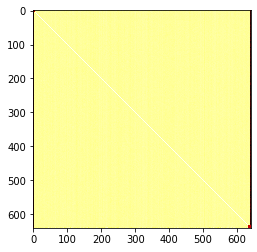

[[0.00148185 0.00148185 0.00148185 ... 0.00148294 0.00148407 0.00148257]
 [0.00148185 0.00148185 0.00148185 ... 0.00148119 0.00148171 0.00148088]
 [0.00148185 0.00148185 0.00148185 ... 0.00148701 0.00148729 0.00148566]
 ...
 [0.00149166 0.00148696 0.00149151 ... 0.00148185 0.00148185 0.00148185]
 [0.00149508 0.00148975 0.00149407 ... 0.00148185 0.00148185 0.00148185]
 [0.00149542 0.00149076 0.00149428 ... 0.00148185 0.00148185 0.00148185]]
True
batch_size:  tf.Tensor(1, shape=(), dtype=int32)
num_frames:  640
len(x_np)/batch_size: tf.Tensor(640.0, shape=(), dtype=float64)
[[0.00148184 0.00148184 0.00148184 ... 0.00148293 0.00148406 0.00148256]
 [0.00148184 0.00148184 0.00148184 ... 0.00148118 0.0014817  0.00148087]
 [0.00148184 0.00148184 0.00148184 ... 0.001487   0.00148728 0.00148565]
 ...
 [0.00149165 0.00148695 0.0014915  ... 0.00148184 0.00148184 0.00148184]
 [0.00149507 0.00148974 0.00149406 ... 0.00148184 0.00148184 0.00148184]
 [0.00149541 0.00149075 0.00149427 ... 0.00148184 0

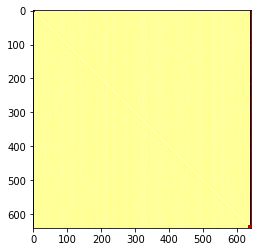

In [11]:
model=ResnetPeriodEstimator()
model(tf.random.uniform((1, 640, 112, 112, 3)))


#img를 model안으로 넣으려면 어떻게 해야하지 일단은 예비값으로 들어간거 같은데
#frames = model.preprocess(frames)